# Density RF Model 

Barebones notebook to reproduce the Murphy et al. [2024] density model. 

Only the model is reproduced, no testing is done (residuals, hyperparameters, permutation importance, etc.). This was done in another set of analysis and removing it here simplifies the notebook. 

In [1]:
import pandas as pd
import numpy as np
import time
import gc
import pickle
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# random state and random forest parameters
# random state ensures the same model is generated

rnd=17
rf_params = {
    "n_estimators": 500,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf":5,
    "warm_start":False,
    "oob_score":True,
    "random_state": rnd,
    "max_features":0.5,
    "n_jobs":10
    }

In [ ]:
def dat_create(dat, col, log_col, lt_col, y_col, t_col):

    x_dat = dat[col+t_col+[y_col]].dropna().copy()

    if log_col:
       for i in log_col:
            try:
                x_dat[i] = np.log10(x_dat[i])
            except:
                print(f'Could not log column {i}')
    
    if lt_col:
        for i in lt_col:
            try:
                if dat[i].max() > 24:
                    x_dat[f'cos_{i}'] = np.cos(dat[i]*2*np.pi/360.)
                    x_dat[f'sin_{i}'] = np.sin(dat[i]*2*np.pi/360.)
                else:
                    x_dat[f'cos_{i}'] = np.cos(dat[i]*2*np.pi/24.)
                    x_dat[f'sin_{i}'] = np.sin(dat[i]*2*np.pi/24.)    
            except:
                print(f'Could not add {i} as a cos/sin time column')
    
    x_dat = x_dat[~x_dat.isin([np.nan, np.inf, -np.inf]).any(axis=1)].dropna()
    y_dat = x_dat[y_col].copy()
    x_dat = x_dat.drop(columns=y_col)    
    
    return x_dat, y_dat

In [ ]:
def rf_model(col=['1300_02', 'SYM_H index','SatLat'], 
             y_col='400kmDensity', 
             t_col=['DateTime'], 
             log_col=['1300_02'], 
             lt_col=['SatMagLT'], 
             rf_params=rf_params, 
             target_dat='D:\\data\\SatDensities\\satdrag_database_grace_B.hdf5', 
             oos_dat='D:\\data\\SatDensities\\satdrag_database_grace_A.hdf5',
             oos_dat2='D:\\data\\SatDensities\\satdrag_database_grace_CHAMP_SI_int.hdf5',
             n_repeats=10):
    
    
    rnd = rf_params['random_state']

    dat_dic = {'feature_cols':col,
               'target_cols':y_col,
               'time_cols':t_col,
               'log_col':log_col,
               'lt_col':lt_col}
    
    kcol = [col,[y_col],t_col,lt_col]
    kflt = [item for sublist in kcol for item in sublist]
    df = pd.read_hdf(target_dat)
    df = df[kflt].dropna()

    reg_x, reg_y = dat_create(dat=df,col=col,log_col=log_col,lt_col=lt_col,
                              y_col=y_col,t_col=t_col)
    reg_y = reg_y*(10**12)
    

    # create data set from out of sample data
    df_oos = pd.read_hdf(oos_dat)
    oos_x, oos_y = dat_create(dat=df_oos,col=col,log_col=log_col,lt_col=lt_col,
                              y_col=y_col,t_col=t_col)
    oos_y = oos_y*(10**12)
    oos_t = oos_x[t_col]
    oos_x = oos_x.drop(columns=t_col)
    

    df_oos2 = pd.read_hdf(oos_dat2)
    oos_x2, oos_y2 = dat_create(dat=df_oos2,col=col,log_col=log_col,lt_col=lt_col,
                                y_col=y_col,t_col=t_col)
    oos_y2 = oos_y2*(10**12)
    oos_t2 = oos_x2[t_col]
    oos_x2 = oos_x2.drop(columns=t_col)

    del df
    del df_oos
    del df_oos2
    gc.collect
    
    # create train test splits
    train_x, test_x, train_y, test_y = train_test_split(reg_x, reg_y, 
                                                        test_size=0.3, 
                                                        random_state=rnd)

    # get and drop DateTime column
    train_t = train_x[t_col].copy()
    test_t = test_x[t_col].copy()

    train_x = train_x.drop(columns=t_col)
    test_x = test_x.drop(columns=t_col)

    print('Train and fit model')

    start = time.time()
    print("Time elapsed working on RandomForest")

    rfr = RandomForestRegressor(**rf_params)
    rfr.fit(train_x, train_y)

    end = time.time()
    print("Time consumed in working: ",end - start)

    #Make predictions and calculate error
    predictions = rfr.predict(test_x)
    pre_oos = rfr.predict(oos_x)
    pre_oos2 = rfr.predict(oos_x2)
    pre_tr = rfr.predict(train_x)
    
    # combine data sets into single dataframes
    train_d = train_x.join([train_y,train_t], how='left')
    test_d = test_x.join([test_y,test_t], how='left')
    oos_d = oos_x.join([oos_y,oos_t], how='left')
    oos2_d = oos_x2.join([oos_y2,oos_t2], how='left')
    
    # add predictions to the dataframes
    train_d[y_col+'_pred'] = pre_tr
    test_d[y_col+'_pred'] = predictions
    oos_d[y_col+'_pred'] = pre_oos
    oos2_d[y_col+'_pred'] = pre_oos2
    
    
    
    return rfr, train_d, test_d, oos_d, oos2_d, dat_dic

In [ ]:
def rf_run(y_col='400kmDensity', 
           lt_col=['SatMagLT'],
           pre_f = False,
           app_f = False
           ):
    """
    Run a set of random forest models 

    Returns
    -------
    None.
    
    Saves data frames to file for subsequent analysis

    """
    
    # out_dir 
    o_dir = 'D:\\data\\SatDensities\\'
    
    # repeats for permutation importance
    n_repeats = 5
    # columns that are not used in the model but are returned
    # to make subsequent analysis easier
    t_col = ['DateTime','storm','storm phase']
    
    # columns to log for fism and geo datasets
    fi_log = ['1300_02', '43000_09', '85550_13', '94400_18']
    
    # solar indice columns
    si_col = ['F10', 'F81', 'S10', 'S81c', 'M10', 'M81c', 'Y10', 'Y81c', 'SatLat']
            
    # fism2 columns
    fi_col = ['1300_02', '43000_09', '85550_13', '94400_18', 'SatLat']
 
    # fism2 and geo columns
    fgeo_col = ['1300_02', '43000_09', '85550_13', '94400_18', 'SYM_H index', 'AE', 'SatLat']

    # labels
    data_labels = ['SI','FI','FI_GEO']
    data_sets = [si_col, fi_col, fgeo_col]

    data_labels = ['FI_GEO']
    data_sets = [fgeo_col]
    
    for col, d_in in zip(data_sets,data_labels):
        
        print(d_in)

        rf_dat = rf_model(y_col=y_col, lt_col=lt_col,
                          col=col, t_col=t_col, log_col=fi_log, 
                          n_repeats=n_repeats)
        
        fn = f'{d_in}_RFdat'
        if pre_f:
            fn = f'{pre_f}{fn}'
        if app_f:
            fn = f'{fn}{app_f}'
            
        fn = f'{fn}.pkl'
        fn = os.path.join(o_dir,fn)
        
        with open(fn, 'wb') as f:
            pickle.dump(rf_dat, f)
            
        del rf_dat
        gc.collect

In [ ]:
rf_run(app_f='_AIMFAHR')

In [1]:
import pandas as pd
mdl_sv = r"D:\data\SatDensities\FI_GEO_RFdat_AIMFAHR.pkl"
mdl_dat = pd.read_pickle(mdl_sv) 
# get the model from the old pickle file
rfr = mdl_dat[0]
# get the input data
feat_dat = mdl_dat[1][rfr.feature_names_in_].copy()

In [5]:
import skops.io as sio
import zipfile
sio.dump(rfr,"D:/data/rfr.skops",compression=zipfile.ZIP_BZIP2, compresslevel=2)

In [6]:
sio.load(file="D:/data/rfr.skops")

RandomForestRegressor(max_features=0.5, min_samples_leaf=5, n_estimators=500,
                      n_jobs=10, oob_score=True, random_state=17)

In [ ]:
import skops.io as sio

obj = sio.dump(rfr, "D:/data/rfr_bz6.skops",compression=zipfile.ZIP_BZIP2, compresslevel=6)

In [1]:
import pandas as pd

In [4]:
df = pd.DataFrame([[0,1,2],[0,1]], index=['hi','b']).transpose()

In [5]:
df

,hi,b
0,0.0,0.0
1,1.0,1.0
2,2.0,NaN


In [ ]:
import skops.io._trusted_types as trusted
from skops.io._utils import get_type_name
from inspect import getmembers
import pandas as pd
df = pd.DataFrame()

val = list()
ind = list()

for w in getmembers(trusted):
    if isinstance(w[1],list) and 'NAMES' in w[0]:
        val.append(w[1])
        ind.append(w[0])

t_type = [x for xs in val for x in xs]

t_df = pd.DataFrame(val,index=ind).transpose()

CONTAINER_TYPE_NAMES
NUMPY_DTYPE_TYPE_NAMES
NUMPY_UFUNC_TYPE_NAMES
PRIMITIVE_TYPE_NAMES
SCIPY_UFUNC_TYPE_NAMES
SKLEARN_ESTIMATOR_TYPE_NAMES


In [4]:
print(t_df.head(5).to_markdown())

|    | CONTAINER_TYPE_NAMES   | NUMPY_DTYPE_TYPE_NAMES   | NUMPY_UFUNC_TYPE_NAMES                | PRIMITIVE_TYPE_NAMES   | SCIPY_UFUNC_TYPE_NAMES      | SKLEARN_ESTIMATOR_TYPE_NAMES                              |
|---:|:-----------------------|:-------------------------|:--------------------------------------|:-----------------------|:----------------------------|:----------------------------------------------------------|
|  0 | builtins.list          | numpy.bool_              | numpy.core._multiarray_umath.absolute | builtins.int           | scipy.special._ufuncs.agm   | sklearn.linear_model._bayes.ARDRegression                 |
|  1 | builtins.set           | numpy.bytes_             | numpy.core._multiarray_umath.add      | builtins.float         | scipy.special._ufuncs.airy  | sklearn.ensemble._weight_boosting.AdaBoostClassifier      |
|  2 | builtins.map           | numpy.clongdouble        | numpy.core._multiarray_umath.arccos   | builtins.str           | scipy.special._ufunc

In [26]:
from skops.io import _trusted_types
from skops.io._utils import get_type_name
from inspect import getmembers

val = list()
ind = list()




def is_trusted(obj)-> bool:

    trust = list()

    for w in getmembers(_trusted_types):
        if 'NAMES' in w[0] and isinstance(w[1],list):
            val.append(w[1])
            ind.append(w[0])

    t_type = [v for vs in val for v in vs]

    if isinstance(obj, list):
        for value in obj:
            trust.append(get_type_name(type(value)) in t_type)
    elif isinstance(obj, dict):
        for value in obj.values():
            trust.append(get_type_name(type(value)) in t_type)
    else:
        trust.append(get_type_name(type(obj)) in t_type)

    return trust




In [27]:
is_trusted(np.int16())
is_trusted({'hi':np.int16(),'b':pd.DataFrame(), 'l':list()})

[True, False, True]

In [12]:
a = {True, True, True}

In [13]:
a

{True}

In [11]:
t_type

['builtins.list',
 'builtins.set',
 'builtins.map',
 'builtins.tuple',
 'numpy.bool_',
 'numpy.bytes_',
 'numpy.clongdouble',
 'numpy.complex128',
 'numpy.complex64',
 'numpy.datetime64',
 'numpy.float16',
 'numpy.float32',
 'numpy.float64',
 'numpy.int16',
 'numpy.int32',
 'numpy.int64',
 'numpy.int8',
 'numpy.intc',
 'numpy.longdouble',
 'numpy.object_',
 'numpy.str_',
 'numpy.timedelta64',
 'numpy.uint16',
 'numpy.uint32',
 'numpy.uint64',
 'numpy.uint8',
 'numpy.uintc',
 'numpy.void',
 'numpy.core._multiarray_umath.absolute',
 'numpy.core._multiarray_umath.add',
 'numpy.core._multiarray_umath.arccos',
 'numpy.core._multiarray_umath.arccosh',
 'numpy.core._multiarray_umath.arcsin',
 'numpy.core._multiarray_umath.arcsinh',
 'numpy.core._multiarray_umath.arctan',
 'numpy.core._multiarray_umath.arctan2',
 'numpy.core._multiarray_umath.arctanh',
 'numpy.core._multiarray_umath.bitwise_and',
 'numpy.core._multiarray_umath.bitwise_or',
 'numpy.core._multiarray_umath.bitwise_xor',
 'numpy.c

In [2]:
import numpy as np
is_trusted(np.int16())

True

In [3]:
import pandas as pd
is_trusted(pd.DataFrame())

False

In [5]:
%%time

for w in getmembers(trusted):
    if isinstance(w[1],list) and 'NAMES' in w[0]:
        val.append(w[1])
        ind.append(w[0])

CPU times: total: 0 ns
Wall time: 0 ns


In [57]:
from skops.io._utils import get_type_name

In [ ]:
unknown_types = sio.get_untrusted_types(file="D:/data/rfr_bz2.skops")

In [26]:
sio.visualize("D:/data/rfr_bz2.skops")

root: sklearn.ensemble._forest.RandomForestRegressor
└── attrs: builtins.dict
    ├── estimator: sklearn.tree._classes.DecisionTreeRegressor
    │   └── attrs: builtins.dict
    │       ├── criterion: json-type("squared_error")
    │       ├── splitter: json-type("best")
    │       ├── max_depth: json-type(null)
    │       ├── min_samples_split: json-type(2)
    │       ├── min_samples_leaf: json-type(1)
    │       ├── min_weight_fraction_leaf: json-type(0.0)
    │       ├── max_features: json-type(null)
    │       ├── max_leaf_nodes: json-type(null)
    │       ├── random_state: json-type(null)
    │       ├── min_impurity_decrease: json-type(0.0)
    │       ├── class_weight: json-type(null)
    │       ├── ccp_alpha: json-type(0.0)
    │       ├── monotonic_cst: json-type(null)
    │       └── _sklearn_version: json-type("1.5.1")
    ├── n_estimators: json-type(500)
    ├── estimator_params: builtins.tuple
    │   ├── content: json-type("criterion")
    │   ├── content: json-typ

In [20]:
loaded = sio.load("D:/data/rfr_bz2.skops")

In [ ]:
loaded.predict

In [36]:
feat_dat

,1300_02,43000_09,85550_13,94400_18,SYM_H index,AE,SatLat,cos_SatMagLT,sin_SatMagLT
200511,7.490862,9.911153,9.455465,9.228625,-15.0,105.0,-60.03617,-0.494025,0.869448
242348,7.465065,9.924064,9.463639,9.232483,-6.0,18.0,-60.03854,-0.870029,0.493001
994822,7.696125,9.986703,9.501317,9.272544,5.0,22.0,-87.11732,0.919029,0.394191
779234,6.966885,9.780912,9.396972,9.171520,-10.0,78.0,25.74049,0.544046,0.839055
623312,6.596638,9.738198,9.379986,9.153376,3.0,19.0,-20.07795,0.625324,-0.780365
...,...,...,...,...,...,...,...,...,...
172003,7.550780,9.954000,9.479843,9.246430,-20.0,301.0,-33.99006,0.350387,0.936605
952506,7.523355,9.920227,9.458151,9.237336,2.0,28.0,-12.79244,0.315881,-0.948799
542667,6.572343,9.752442,9.385822,9.157213,-12.0,56.0,-15.53038,0.217837,0.975985
346251,7.313595,9.831315,9.418499,9.188301,-15.0,98.0,71.51182,0.148465,-0.988918


In [37]:
xx = loaded.predict(feat_dat)

In [40]:
import matplotlib.pyplot as plt

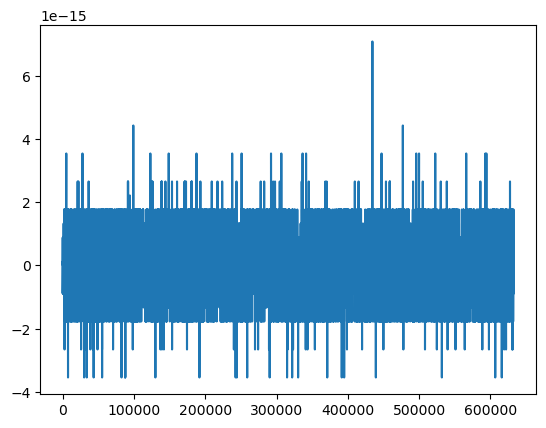

In [41]:
plt.plot(xx-mdl_dat[1]['400kmDensity_pred'].to_numpy())

In [15]:
import os
import os.path
import time
start = time.time()
pickle_file = "D:/data/rfr_bz2_6.joblib"
with open(pickle_file, "wb") as f:
    dump(rfr, f, compress=('bz2',6))
raw_dump_duration = time.time() - start
print("Raw dump duration: %0.3fs" % raw_dump_duration)

Raw dump duration: 120.622s


In [22]:
start = time.time()
with open(pickle_file, "rb") as f:
    load("D:/data/rfr_bz2.joblib")
raw_load_duration = time.time() - start
print("Raw load duration: %0.3fs" % raw_load_duration)

Raw load duration: 62.782s


In [ ]:
feat_dat

In [ ]:
feat_dat.to_numpy()

In [ ]:
from skl2onnx import to_onnx
onx = to_onnx(rfr, feat_dat[:1].to_numpy())

In [ ]:
with open("D:/data/rf_tdm.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [ ]:
size(onx)

In [ ]:
rfr